# Makemore - Character-level Language Model

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
min(words, key=len), min(len(w) for w in words)

('an', 2)

In [6]:
max(words, key=len), max(len(w) for w in words)

('muhammadibrahim', 15)

**Bigram LM** - works only with 2 chars (bi - two).<br>
Looking at 1 char it tries to predict the following char

In [7]:
for w in words[:3]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)
    print("-"*15)
        

e m
m m
m a
---------------
o l
l i
i v
v i
i a
---------------
a v
v a
---------------


In [8]:
b = {}
for w in words[:3]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1  # Counting frequency of each bigram
        print(ch1, ch2)
    print("-"*15)

<S> e
e m
m m
m a
a <E>
---------------
<S> o
o l
l i
i v
v i
i a
a <E>
---------------
<S> a
a v
v a
a <E>
---------------


In [9]:
b

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [10]:
# Let's do for all words!

b = {}
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [11]:
frequencies = sorted(b.items(), key=lambda kv: kv[1])  # Sort by count
print(frequencies[0])  # Least frequent bigram
print(frequencies[-1])  # Most frequent bigram

(('q', 'r'), 1)
(('n', '.'), 6763)


In [12]:
import torch

In [13]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}  # map char to position
stoi["."] = 0

In [14]:
"""
Instead of working with dict we'd rather use a matrix
where each row is the first char and column is the second character
interesection of these will represent frequency (count) of char2 following char1
"""
N = torch.zeros((27, 27), dtype=torch.int32)  # 26 eng letters + 1 special symbol

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1  # Counting in this 27x27 matrix

In [15]:
N[stoi["n"], 0]  # <E> following n. Works like a charm!

tensor(6763, dtype=torch.int32)

In [16]:
import matplotlib.pyplot as plt

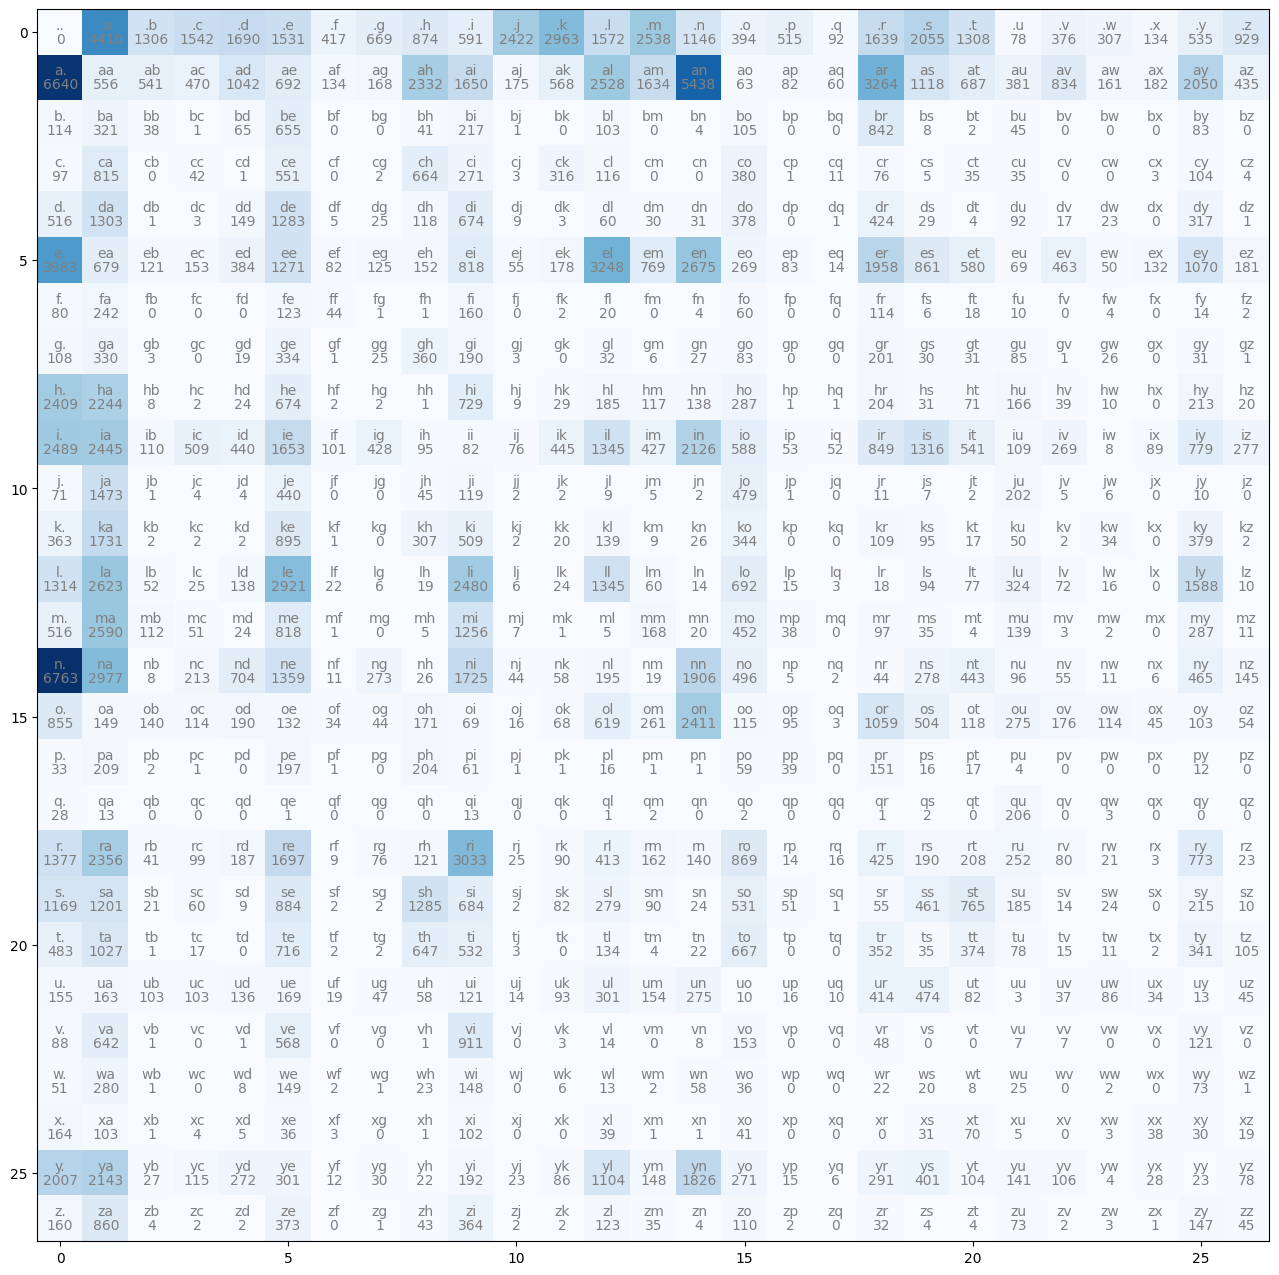

In [17]:
itos = {i:s for s, i in stoi.items()}

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues");

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

In [18]:
g = torch.Generator().manual_seed(2147483647)
P = N.float()
P /= P.sum(dim=1, keepdim=True)

for i in range(20):
    ix = 0
    res = ""
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        res += itos[ix]
    print(res)

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core
yaenon
ka
jabdinerimikimaynin
anaasn
ssorionsush


## Max likelihood based model
For model quality estimation we need to have some way of measuring its performance.<br>
At its current state our model is quite dumb (somewhat similar to KNN), since it uses simple quantity patterns of the data.

In [19]:
for w in words[:3]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f"{ch1}{ch2}: {prob:.4f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


As we can see we've learnt meaningful statistics from the data, since some of the probabilities are higher than 1/27 (in case all of probas would be equally likely and meaningless). Though It would be better to say that our data contains meaningful information, because we didn't learning anything ourselves, we just analyzed the data.<br>
The higher probability, the better, since it means our model covers real data with probability 1.0 (true positives).<br>
To measure on full dataset we should multiply probabilities (likelihood), but since all these numbers belong to [0; 1], multiplication of them is a terrible idea, so instead we use logarithms (log likelihood).<br>
Conveniently Log(product) = sum(logs), so we work with summation of log probabilities.<br>
For smaller probabilities log assigns smaller negative number, so our goal is to maximize total log-likelihood.<br>
Since minimization problems in DL are more common we try to **minimize Negative Log-Likelihood**

In [20]:
likelihood = 0
i = 0
for w in words[:3]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        i += 1
        likelihood -= torch.log(prob)
        
print(f"Total Negative log-likelihood: {likelihood:.4f}")
print(f"Avg Negative log-likelihood: {likelihood / i:.4f}")

Total Negative log-likelihood: 38.7856
Avg Negative log-likelihood: 2.4241


In [22]:
likelihood = 0
i = 0
for w in ["cheslaffp"]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        i += 1
        likelihood -= torch.log(prob)
        
print(f"Total Negative log-likelihood: {likelihood:.4f}")
print(f"Avg Negative log-likelihood: {likelihood / i:.4f}")

Total Negative log-likelihood: inf
Avg Negative log-likelihood: inf


Oh shish... Why does it happen like this?<br>
The thing is that some bigrams appear 0 times in our data, so for this very bigram prob=0.0 and log(0.0) is -inf.
Adding it to our negative log-likelihood makes it inf. And inf loss isn't what we want for names that are actually possible.<br>
The thing we can do is to add 1 to each cell in probability matrix P

In [23]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

In [24]:
likelihood = 0
i = 0
for w in ["cheslaffp"]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        i += 1
        likelihood -= torch.log(prob)
        
print(f"Total Negative log-likelihood: {likelihood:.4f}")
print(f"Avg Negative log-likelihood: {likelihood / i:.4f}")

Total Negative log-likelihood: 34.1741
Avg Negative log-likelihood: 3.4174


# Neural Networks approach!
We used simple statistical bigram model, but techniqally we can predict probability of next character by input character.<br>
We have loss function, we have optimizers, so what holds us back?

In [25]:
xs, ys = [], []

for w in words:
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [26]:
xs[:5], ys[:5]

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [27]:
import torch.nn.functional as F

x_enc = F.one_hot(xs, num_classes=27).float()

In [28]:
x_enc.shape

torch.Size([228146, 27])

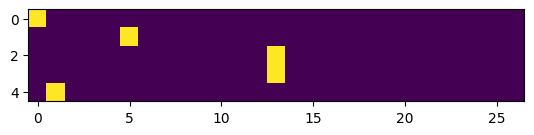

In [29]:
plt.imshow(x_enc[:5]);

In [30]:
W = torch.randn((27, 27))
sample = x_enc[:5]
sample @ W  # (5, 27) @ (27, 27) -> (5, 27)

tensor([[ 0.5174, -0.7052,  0.0521, -0.1020, -1.0071, -0.3629,  0.6184, -0.5947,
          0.5236, -1.5606,  1.5329, -0.1262, -1.0879, -0.3856, -0.3561,  1.0160,
         -2.3001, -0.9864, -0.2933,  0.2983, -1.2522, -0.1726,  0.1632, -0.5094,
          0.7805, -0.7720,  0.8648],
        [-0.0717, -0.2928,  0.1983,  0.9332, -1.2210, -0.0724, -0.6276, -0.7178,
          0.9038,  0.1896,  1.3655,  1.9940, -1.8656,  0.2859,  1.0508,  1.8986,
         -0.9733,  0.5555, -0.5389,  1.6071, -0.4832,  0.1549, -1.4547,  0.2322,
          0.8782, -0.0488,  1.5797],
        [ 0.6567,  0.9832,  1.1742, -0.9667, -1.9189,  1.6672, -0.4796,  1.2519,
          0.3489, -1.8988, -0.8107, -0.8983, -0.3310,  1.2430, -0.9697, -0.1568,
          0.3005,  0.7998,  0.6940,  0.2134,  0.5804,  0.5430, -0.4673, -0.0371,
         -0.2031, -0.1399, -0.3206],
        [ 0.6567,  0.9832,  1.1742, -0.9667, -1.9189,  1.6672, -0.4796,  1.2519,
          0.3489, -1.8988, -0.8107, -0.8983, -0.3310,  1.2430, -0.9697, -0.1568

In [31]:
(sample @ W)[2, 5]  # Firing rate for 5th neuron given 2nd character

tensor(1.6672)

Okay, let's work with this 1 layered network for now.<br>
It has 27 output neurons for character we pass in.<br>
But what is the meaning of it? Well, these are not probabilities, since they don't fit [0;1] range and don't sum up to 1.<br>
We can think of them as log() of counts (see count matrix).<br>
For each character passed in we have row of counts & we can interpret our network learning logarithm of these counts.<br>
To inverse it and get counts we can exponentiate our **raw logits**

In [32]:
logits = sample @ W  # log-counts
counts = logits.exp()  # Equivalent to N matrix
probs = counts / counts.sum(dim=1, keepdims=True)
probs

tensor([[0.0560, 0.0165, 0.0351, 0.0301, 0.0122, 0.0232, 0.0619, 0.0184, 0.0563,
         0.0070, 0.1545, 0.0294, 0.0112, 0.0227, 0.0234, 0.0921, 0.0033, 0.0124,
         0.0249, 0.0450, 0.0095, 0.0281, 0.0393, 0.0200, 0.0728, 0.0154, 0.0792],
        [0.0176, 0.0141, 0.0231, 0.0481, 0.0056, 0.0176, 0.0101, 0.0092, 0.0467,
         0.0229, 0.0742, 0.1390, 0.0029, 0.0252, 0.0541, 0.1264, 0.0072, 0.0330,
         0.0110, 0.0944, 0.0117, 0.0221, 0.0044, 0.0239, 0.0456, 0.0180, 0.0919],
        [0.0483, 0.0669, 0.0810, 0.0095, 0.0037, 0.1326, 0.0155, 0.0876, 0.0355,
         0.0037, 0.0111, 0.0102, 0.0180, 0.0868, 0.0095, 0.0214, 0.0338, 0.0557,
         0.0501, 0.0310, 0.0447, 0.0431, 0.0157, 0.0241, 0.0204, 0.0218, 0.0182],
        [0.0483, 0.0669, 0.0810, 0.0095, 0.0037, 0.1326, 0.0155, 0.0876, 0.0355,
         0.0037, 0.0111, 0.0102, 0.0180, 0.0868, 0.0095, 0.0214, 0.0338, 0.0557,
         0.0501, 0.0310, 0.0447, 0.0431, 0.0157, 0.0241, 0.0204, 0.0218, 0.0182],
        [0.0507, 0.0013,

In [33]:
probs.sum(dim=1)  # All rows sum to 1

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Congrats! We not only understood meaning of forward prop in our project, but we also understood softmax meaning!<br>
We built it ourselves exponentiating logits first and then normalizing them!

# Learning Time!!!

In [34]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
# Forward pass
x_enc = F.one_hot(xs, num_classes=27).float()
logits = x_enc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(5), ys[:5]].log().mean()
loss

tensor(3.7693, grad_fn=<NegBackward0>)

In [35]:
# Backward pass
W.grad = None  # Set grad to zero
loss.backward()

In [36]:
W.data += -0.1 * W.grad

In [37]:
# Forward pass again to make sure loss decreased

# Forward pass
x_enc = F.one_hot(xs, num_classes=27).float()
logits = x_enc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(5), ys[:5]].log().mean()
loss

tensor(3.7492, grad_fn=<NegBackward0>)

# Putting it all together!

In [38]:
# Data setup
xs, ys = [], []

for word in words:
    chars = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"Number of examples: {num}")

Number of examples: 228146


In [39]:
# Parameter Initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [40]:
# Training

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    if epoch % 10 == 0: print(loss.item())
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

3.758953332901001
2.6890032291412354
2.572789192199707
2.5301806926727295
2.5086872577667236
2.496137857437134
2.488049268722534
2.482424259185791
2.478290557861328
2.475132703781128


Wonderful! We got roughly the same performance with neural network as we did statistically, but neural network approach is extandable and really flexible. We can run for as many iterations as we want, with different hyperparameter settings, not to mention we can construct a deeper model, so it performs better (because now we have a shallow neural network).

## **Interesting details!**
Let's think of what is x_enc in forward prop.<br>
For one sample it is a vector filled with zeros except one column, which is 1.<br>
That's to mention that in dot product we ignore all the W rows except the one multiplied by 1.<br>
We sort of **apply the mask** to our weights matrix.<br>
And the result of this dot product are logits. It means that exponentiated Weights matrix is our counts matrix N!
This masking by x_enc is like selecting the row with starting char and dot product results in highliting the row of log counts!
Let's see!

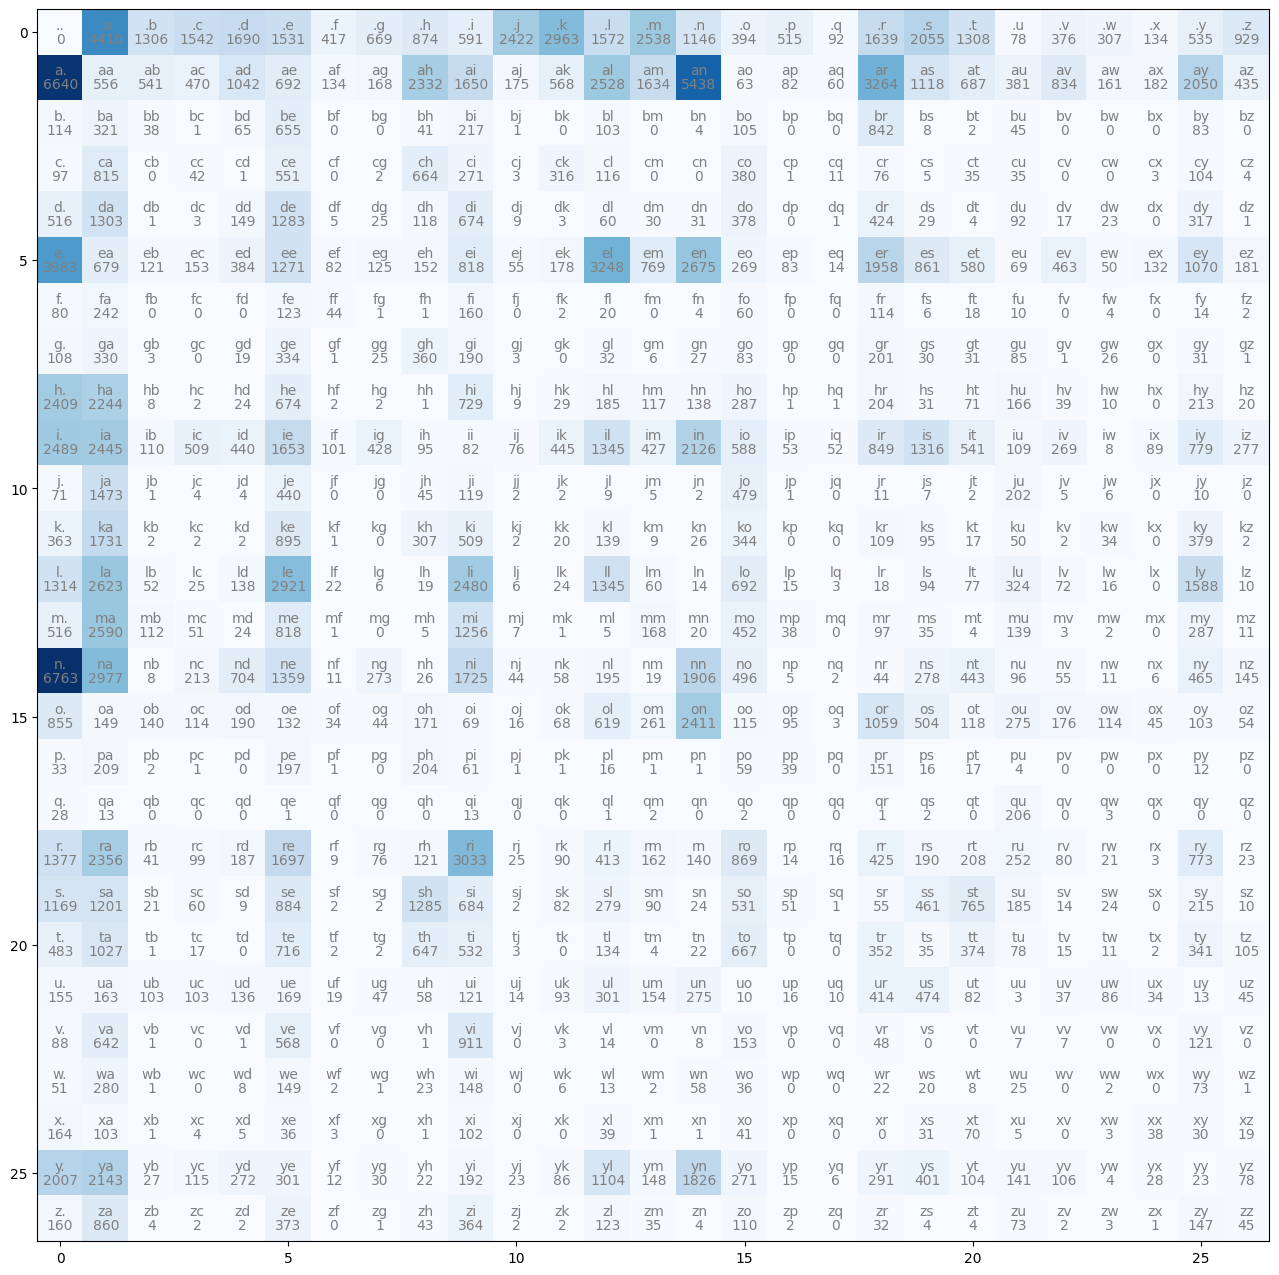

In [41]:
itos = {i:s for s, i in stoi.items()}

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues");

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

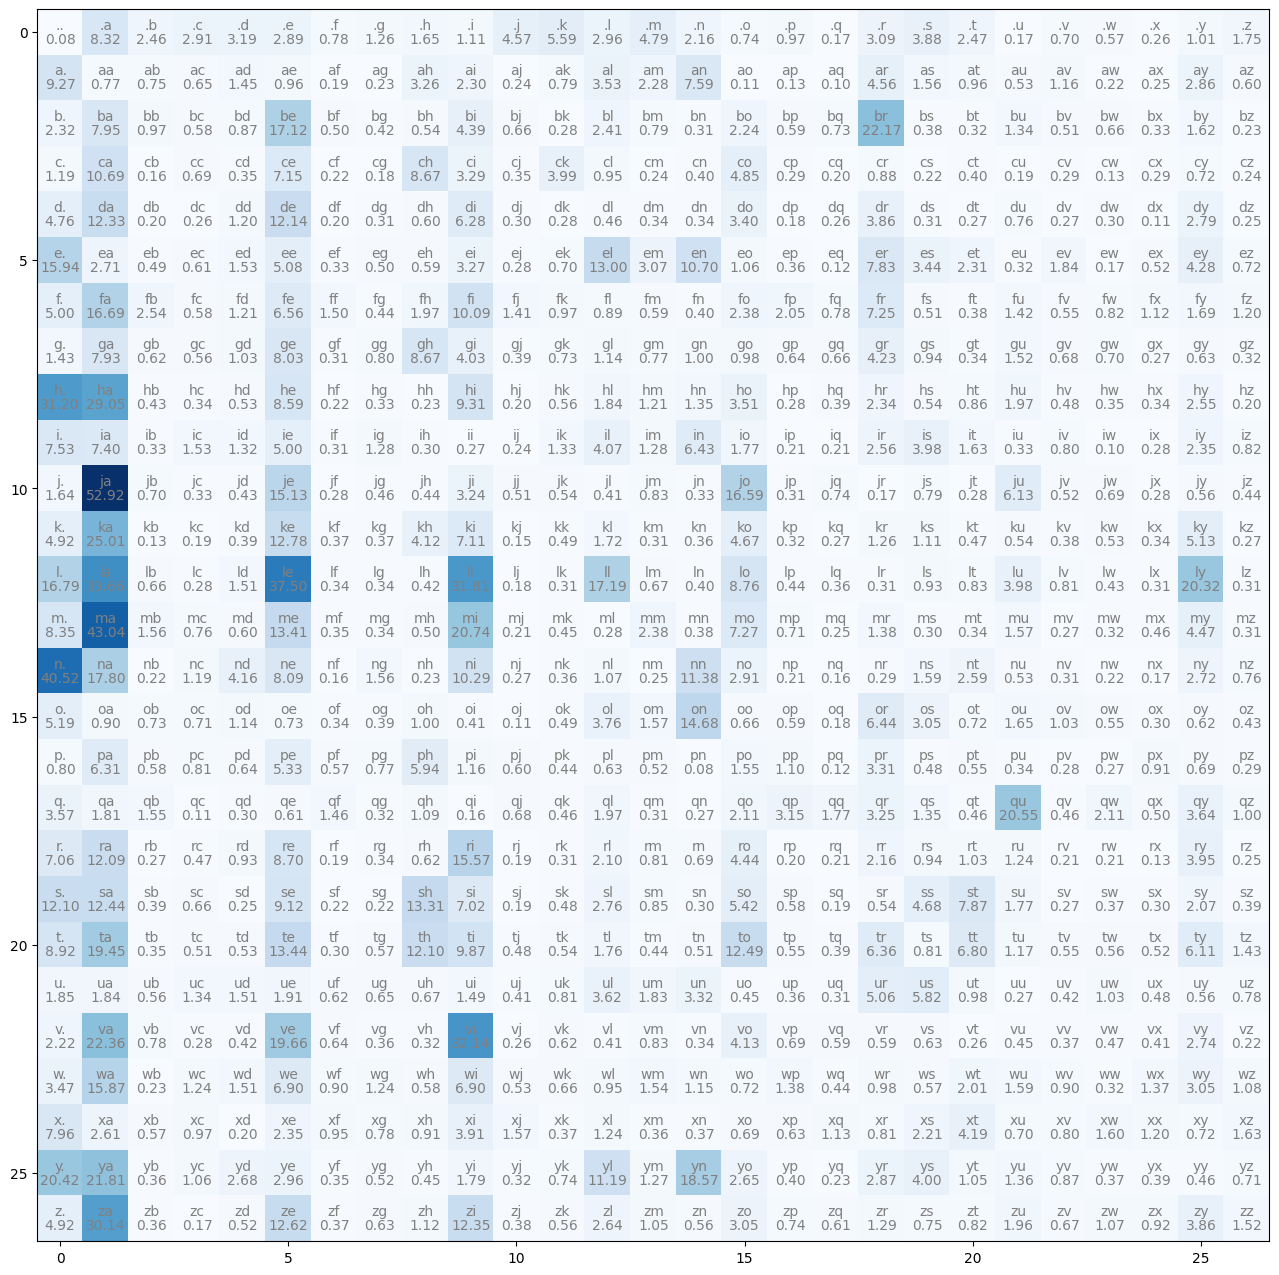

In [42]:
itos = {i:s for s, i in stoi.items()}

learned_N_matrix = W.exp().detach().numpy()

plt.figure(figsize=(16, 16))
plt.imshow(learned_N_matrix, cmap="Blues");

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f"{learned_N_matrix[i, j].item():.2f}", ha="center", va="top", color="gray")

### Now we see that our learned N matrix differs from original a little, but general relations are somewhat simmilar.
Keep in mind that it can be easily fixed extending our network.

## Another interesting detail!
In statistical approach we have a **smoothing** idea when we add some number to N (used to avoid 0 counts).<br>
The thing is, the bigger term we add, the smoother and more uniform probabilities would be.<br>
In NN approach we achieve simmilar results with L2 regularization, since it adds this **force** (like gravity) that drives weights to be zeros. Zero weights result in zero log-likelihood. Exp of 0 is 1. Softmax of 1 results in 1 / n (equally likely probability).
Not really good, having such a powerful force, but we can tune it with special **regularization coefficient**.
The bigger coefficient, the smoother the distribution.<br>
Having it in some concentration is helpful to avoid overfitting

In [43]:
# Training with regularization

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    if epoch % 10 == 0: print(loss.item())
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

3.768618583679199
2.696505308151245
2.5822560787200928
2.5413525104522705
2.52126407623291
2.509854793548584
2.5027060508728027
2.4978790283203125
2.494438648223877
2.4918932914733887


In [44]:
# Training with strong regularization

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 1 * (W**2).mean()
    if epoch % 10 == 0: print(loss.item())
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

4.725468635559082
2.919663906097412
2.892893075942993
2.892038345336914
2.892005681991577
2.8920042514801025
2.8920037746429443
2.8920040130615234
2.8920040130615234
2.8920040130615234


### Boom! Gravity is too strong, so we can't make our model fly! It's like changing weights results in the loss growth.
Let's see weights row

In [45]:
# Training with super strong regularization

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 10 * (W**2).mean()
    if epoch % 10 == 0: print(loss.item())
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

13.424107551574707
3.2095654010772705
3.2081663608551025
3.2080752849578857
3.2080681324005127
3.2080671787261963
3.208066940307617
3.208066940307617
3.2080674171447754
3.208066940307617


In [46]:
W[0]  # All close to 0

tensor([-0.1600,  0.4191,  0.0176,  0.0492,  0.0689,  0.0477, -0.1028, -0.0684,
        -0.0406, -0.0791,  0.1654,  0.2357,  0.0532,  0.1806, -0.0039, -0.1059,
        -0.0894, -0.1473,  0.0621,  0.1172,  0.0178, -0.1493, -0.1084, -0.1178,
        -0.1416, -0.0867, -0.0332], grad_fn=<SelectBackward0>)

# Finally, sampling from our model!

In [47]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    ix = 0
    res = ""
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()  # Starting with special token
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        res += itos[ix]
    print(res)

juwjdvdipkaqaz
p
cfqywocnnqfjiirltozcogsjgwzvudlhnpauyabilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumj
pfynszwjhrjagq
coreaysezocfkyjjabdiwejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpacicz
rjpiufmthdt
rkrrsru
iyumuyfy
mjekujcbkhvupwyhlpvhvccragr
wdkhwfdztta
mplyisbxlyhugi
zavmpocbzthqmimvyqwat
f

sdxjxfpvslqtikyzsaloevgvvnundewkfmbjzqemruxiteaxchwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelv
viosvhibdhnceukgmtmwbrscnbzoiwupnwnpipixtewbgsgyewfdacbfcxrvjypkmsbranmjrdsydotafvkdkbdepihzpwzsqdab
vfuolwbahrtugttbiqbujfdtskceqjtcdlcndfrjqllsppgkltalmlokdmal
fddmxjv
mfsgxmw
vdihkvngtojvrdsyqivcou


## What?!? No worries, it's because of those crazy experiments with regularization!

In [48]:
# Parameter Initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

# Training

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    if epoch % 10 == 0: print(loss.item())
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

3.758953332901001
2.6890032291412354
2.572789192199707
2.5301806926727295
2.5086872577667236
2.496137857437134
2.488049268722534
2.482424259185791
2.478290557861328
2.475132703781128


In [49]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    ix = 0
    res = ""
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()  # Starting with special token
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        res += itos[ix]
    print(res)

junide
janasah
p
cfay
a
nn
kohin
tolian
juwe
kilanaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core
yaenon
ka
jabi
werimikimaynin
anaasn


### There we go! Same silly names, but all because of how shallow our network is.
### It literally replicates statistical model (for reasons described above)

---

# Exercises!


In [50]:
# E01 Train A Trigram Language Model and see whether performance improves!

In [106]:
# Alright, let's see. Possible approach is to create a simmilar indexing system for bigrams (though it grows exponentially).
# Then These encoded bigrams can be encoded.

chars = sorted(set(list("".join(words))))
chars = ["."] + chars

btoi = {}
i = 0
for char1 in chars:
    for char2 in chars:
        bigram = char1 + char2
        if bigram != "..":
            btoi[bigram] = i
            i += 1

In [107]:
X = []
y = []

for word in words:
    chars = ["."] + list(word) + ["."]
    for i in range(len(chars)-2):
        bigram = chars[i] + chars[i+1]
        X.append(btoi[bigram])
        y.append(stoi[chars[i+2]])

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

(torch.Size([196113]), torch.Size([196113]))

In [108]:
n_bigrams = len(btoi.items())
n_bigrams

728

In [109]:
X_enc = F.one_hot(X, num_classes=n_bigrams).float()
X_enc.shape

torch.Size([196113, 728])

In [113]:
W = torch.randn((728, 27), generator=g, requires_grad=True)  # Shallow net again
b = torch.randn(27, generator=g, requires_grad=True)
lr = 10

for epoch in range(300):
    # forward pass
    logits = X_enc @ W + b
    count = logits.exp()
    probas = count / count.sum(dim=1, keepdims=True)
    loss = -probas[torch.arange(X.shape[0]), y].log().mean()
    W.grad = None
    b.grad = None
    loss.backward()
    W.data += -lr * W.grad
    b.data += -lr * b.grad
    if epoch % 50 == 0: print(loss.item())

4.357230186462402
2.7458913326263428
2.5869011878967285
2.49796986579895
2.43802547454834
2.3939802646636963


In [119]:
# Now this model seems to work (I hope), but this is not great method since we need to pass starter character initially
# We can't start with '..'

for i in range(10):
    res = "e"
    context = ".e"
    while True:
        index = btoi[context]
        logits = X_enc[index] @ W + b
        counts = logits.exp()
        probs = counts / counts.sum()
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + itos[ix]
        if ix == 0:
            break
        res += itos[ix]
    print(res)

eminrem
edoonelvrralhsaxearcav
ez
ettllyanea
enlenheemleant
ea
ernmhh
eenno
eioikosadit
ergn


## Lol ez and eminrem!

Emmmm... Okaaaaay... Let's try different sussy method (dunno whether it's legal or not)

In [120]:
X1 = []
X2 = []
y = []

for word in words:
    chars = ["."] + list(word) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        X1.append(stoi[ch1])
        X2.append(stoi[ch2])
        y.append(stoi[ch3])

X1 = torch.tensor(X1)
X2 = torch.tensor(X2)
y = torch.tensor(y)

X1.shape, X2.shape, y.shape

(torch.Size([196113]), torch.Size([196113]), torch.Size([196113]))

In [121]:
X1_enc = F.one_hot(X1, num_classes=27).float()
X2_enc = F.one_hot(X2, num_classes=27).float()

In [122]:
W = torch.randn((54, 27), generator=g, requires_grad=True)  # Shallow net again
b = torch.randn(27, generator=g, requires_grad=True)
lr = 10

for epoch in range(300):
    # forward pass
    X_con = torch.cat([X1_enc, X2_enc], dim=1)
    logits = X_con @ W + b
    count = logits.exp()
    probas = count / count.sum(dim=1, keepdims=True)
    loss = -probas[torch.arange(X.shape[0]), y].log().mean()
    W.grad = None
    b.grad = None
    loss.backward()
    W.data += -lr * W.grad
    b.data += -lr * b.grad
    if epoch % 50 == 0: print(loss.item())

4.602355003356934
2.439415454864502
2.352545738220215
2.31673002243042
2.296480178833008
2.2835195064544678


In [123]:
for i in range(10):
    res = ""
    ix1, ix2 = 0, 0  # Start with ..
    while True:
        ix1_enc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        ix2_enc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        ix_con = torch.cat([ix1_enc, ix2_enc], dim=1)
        logits = ix_con @ W + b
        counts = logits.exp()
        probas = counts / counts.sum(dim=1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
        if ix2 == 0: break
        res += itos[ix2]
    print(res)

lyah
orjeilus
ie
tory
eloni
ri
riy
roptelin
rakene
rine


In [103]:
# E02 Split data randomly into 80% train, 10% val 10% test

In [148]:
# Bigram data setup
X, y = [], []

for word in words:
    chars = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        y.append(ix2)

X = torch.tensor(xs)
y = torch.tensor(ys)

/tmp/ipykernel_14338/2978053115.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(xs)
/tmp/ipykernel_14338/2978053115.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(ys)


In [149]:
import random

random.seed(42)
indices = torch.arange(0, X.shape[0])
random.shuffle(indices)

In [150]:
train_ratio = 0.8
val_ratio = 0.1

m = indices.shape[0]

train_indices = indices[:int(m * train_ratio)]
val_indices = indices[int(m*train_ratio):int(m*(train_ratio+val_ratio))]
test_indices = indices[int(m*(train_ratio+val_ratio)):]

print(train_indices.numel(), val_indices.numel(), test_indices.numel())
print(train_indices.numel() + val_indices.numel() + test_indices.numel() == m)

182516 22815 22815
True


In [151]:
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [162]:
# Bigram first! (Nothing new here)

# Parameter Initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

# Training

lr = 50
for epoch in range(100):
    # Forward pass
    x_enc = F.one_hot(X_train, num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(0, X_train.nelement()), y_train].log().mean()
    if epoch % 10 == 0:
        xval_enc = F.one_hot(X_val, num_classes=27).float()
        logits = x_enc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        val_loss = -probs[torch.arange(0, X_val.nelement()), y_val].log().mean()
        print(f"Train loss: {loss.item()} | Val loss: {val_loss.item()}")
    # Optimization
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad

Train loss: 3.78542423248291 | Val loss: 3.7504520416259766
Train loss: 2.581374406814575 | Val loss: 3.2664108276367188
Train loss: 2.4695844650268555 | Val loss: 3.2837376594543457
Train loss: 2.4272167682647705 | Val loss: 3.303227424621582
Train loss: 2.405696392059326 | Val loss: 3.320747137069702
Train loss: 2.3928494453430176 | Val loss: 3.3358449935913086
Train loss: 2.3843917846679688 | Val loss: 3.3487563133239746
Train loss: 2.3784313201904297 | Val loss: 3.3598971366882324
Train loss: 2.374019145965576 | Val loss: 3.3696467876434326
Train loss: 2.3706321716308594 | Val loss: 3.3782906532287598


In [163]:
for i in range(20):
    ix = 0
    res = ""
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()  # Starting with special token
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        res += itos[ix]
    print(res)

"""
Wow! We discovered that our model is overfitting!
However, we do it now to see behaviour, not to fix anything (but tbh I think it's both overfitting and underfitting here)
"""

mory
bradeela
azyarileri
chaiadayra
fbrlyar
meyalynza
sabran
h
n
ke
etametteronakan
lalastan
amyonanisemynn
wwlixie
kadareka
jojagkine
fian
kicnaylula
lvy
b


In [164]:
# Now trigram (shish it's gonna be tough)

X1 = []
X2 = []
y = []

for word in words:
    chars = ["."] + list(word) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        X1.append(stoi[ch1])
        X2.append(stoi[ch2])
        y.append(stoi[ch3])

X1 = torch.tensor(X1)
X2 = torch.tensor(X2)
y = torch.tensor(y)

X1.shape, X2.shape, y.shape

(torch.Size([196113]), torch.Size([196113]), torch.Size([196113]))

In [165]:
random.seed(42)
assert X1.shape == X2.shape
indices = torch.arange(0, X1.shape[0])
random.shuffle(indices)

train_ratio = 0.8
val_ratio = 0.1

m = indices.shape[0]

train_indices = indices[:int(m * train_ratio)]
val_indices = indices[int(m*train_ratio):int(m*(train_ratio+val_ratio))]
test_indices = indices[int(m*(train_ratio+val_ratio)):]

print(train_indices.numel(), val_indices.numel(), test_indices.numel())
print(train_indices.numel() + val_indices.numel() + test_indices.numel() == m)

X1_train = X1[train_indices]
X2_train = X2[train_indices]
y_train = y[train_indices]

X1_val = X1[val_indices]
X2_val = X2[val_indices]
y_val = y[val_indices]

X1_test = X1[test_indices]
X2_test = X2[test_indices]
y_test = y[test_indices]

156890 19611 19612
True


In [167]:
X1t_enc = F.one_hot(X1_train, num_classes=27).float()
X2t_enc = F.one_hot(X2_train, num_classes=27).float()

X1v_enc = F.one_hot(X1_val, num_classes=27).float()
X2v_enc = F.one_hot(X2_val, num_classes=27).float()

X1tst_enc = F.one_hot(X1_test, num_classes=27).float()
X2tst_enc = F.one_hot(X2_test, num_classes=27).float()

In [175]:
W = torch.randn((54, 27), generator=g, requires_grad=True)  # Shallow net again
b = torch.randn(27, generator=g, requires_grad=True)
lr = 10

for epoch in range(300):
    # forward pass
    Xt_con = torch.cat([X1t_enc, X2t_enc], dim=1)
    logits = Xt_con @ W + b
    count = logits.exp()
    probas = count / count.sum(dim=1, keepdims=True)
    loss = -probas[torch.arange(0, X1_train.nelement()), y_train].log().mean()
    W.grad = None
    b.grad = None
    loss.backward()
    W.data += -lr * W.grad
    b.data += -lr * b.grad
    if epoch % 50 == 0:
        Xv_con = torch.cat([X1v_enc, X2v_enc], dim=1)
        logits = Xv_con @ W + b
        count = logits.exp()
        probas = count / count.sum(dim=1, keepdims=True)
        val_loss = -probas[torch.arange(0, X1_val.nelement()), y_val].log().mean()
        print(f"Train loss: {loss.item()} | Val loss: {val_loss.item()}")

Train loss: 4.782792091369629 | Val loss: 3.929368019104004
Train loss: 2.3072776794433594 | Val loss: 2.445826768875122
Train loss: 2.2135469913482666 | Val loss: 2.358698606491089
Train loss: 2.1765573024749756 | Val loss: 2.325150728225708
Train loss: 2.1562838554382324 | Val loss: 2.306830406188965
Train loss: 2.1434035301208496 | Val loss: 2.2951862812042236


In [172]:
X1_train.nelement(),

156890

In [177]:
for i in range(10):
    res = ""
    ix1, ix2 = 0, 0  # Start with ..
    while True:
        ix1_enc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        ix2_enc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        ix_con = torch.cat([ix1_enc, ix2_enc], dim=1)
        logits = ix_con @ W + b
        counts = logits.exp()
        probas = counts / counts.sum(dim=1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
        if ix2 == 0: break
        res += itos[ix2]
    print(res)

# Here it's also overfitting, but it's not this critical. Diff ain't this big, so it's more underfitting.

ouslan
malli
cui
orenfettinttyahsakhijersinarye
usishane
ori
ariicas
amabricelenzelexiee
na
za


In [202]:
# E03 Pick regularization using Val set.
W = torch.randn((54, 27), generator=g, requires_grad=True)  # Shallow net again
b = torch.randn(27, generator=g, requires_grad=True)

lr = 10
reg_coeff = 0.01

for epoch in range(500):
    # forward pass
    Xt_con = torch.cat([X1t_enc, X2t_enc], dim=1)
    logits = Xt_con @ W + b
    count = logits.exp()
    probas = count / count.sum(dim=1, keepdims=True)
    loss = -probas[torch.arange(0, X1_train.nelement()), y_train].log().mean() + reg_coeff * torch.mean(W**2)
    W.grad = None
    b.grad = None
    loss.backward()
    W.data += -lr * W.grad
    b.data += -lr * b.grad
    if epoch % 50 == 0:
        Xv_con = torch.cat([X1v_enc, X2v_enc], dim=1)
        logits = Xv_con @ W + b
        count = logits.exp()
        probas = count / count.sum(dim=1, keepdims=True)
        val_loss = -probas[torch.arange(0, X1_val.nelement()), y_val].log().mean()
        print(f"Train loss: {loss.item()} | Val loss: {val_loss.item()}")

Train loss: 4.897367477416992 | Val loss: 3.8799285888671875
Train loss: 2.3151254653930664 | Val loss: 2.447232961654663
Train loss: 2.2235584259033203 | Val loss: 2.3635058403015137
Train loss: 2.1854374408721924 | Val loss: 2.3284308910369873
Train loss: 2.1639621257781982 | Val loss: 2.3080039024353027
Train loss: 2.150207996368408 | Val loss: 2.2945966720581055
Train loss: 2.1407690048217773 | Val loss: 2.285292625427246
Train loss: 2.1340014934539795 | Val loss: 2.2786076068878174
Train loss: 2.128995180130005 | Val loss: 2.2736730575561523
Train loss: 2.1251916885375977 | Val loss: 2.2699368000030518


In [205]:
for i in range(10):
    res = ""
    ix1, ix2 = 0, 0  # Start with ..
    while True:
        ix1_enc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        ix2_enc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        ix_con = torch.cat([ix1_enc, ix2_enc], dim=1)
        logits = ix_con @ W + b
        counts = logits.exp()
        probas = counts / counts.sum(dim=1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
        if ix2 == 0: break
        res += itos[ix2]
    print(res)

# Picked, but honestly not sure about correctness

esadia
ainahrperlenn
diya
lanitleivakeelgy
andinna
ovberili
eiy
luine
urinven
lix


In [213]:
# E05 Use F.cross_entropy
W = torch.randn((54, 27), generator=g, requires_grad=True)  # Shallow net again
b = torch.randn(27, generator=g, requires_grad=True)

lr = 10

for epoch in range(500):
    # forward pass
    Xt_con = torch.cat([X1t_enc, X2t_enc], dim=1)
    logits = Xt_con @ W + b
    loss = F.cross_entropy(logits, y_train)
    W.grad = None
    b.grad = None
    loss.backward()
    W.data += -lr * W.grad
    b.data += -lr * b.grad
    if epoch % 50 == 0:
        Xv_con = torch.cat([X1v_enc, X2v_enc], dim=1)
        logits = Xv_con @ W + b
        val_loss = F.cross_entropy(logits, y_val)
        print(f"Train loss: {loss.item()} | Val loss: {val_loss.item()}")

Train loss: 4.387199401855469 | Val loss: 3.572056293487549
Train loss: 2.300963878631592 | Val loss: 2.4384586811065674
Train loss: 2.2041268348693848 | Val loss: 2.351813793182373
Train loss: 2.1690948009490967 | Val loss: 2.3198752403259277
Train loss: 2.1508126258850098 | Val loss: 2.3026490211486816
Train loss: 2.1393535137176514 | Val loss: 2.2916228771209717
Train loss: 2.1314241886138916 | Val loss: 2.2839367389678955
Train loss: 2.1255829334259033 | Val loss: 2.2782785892486572
Train loss: 2.1210901737213135 | Val loss: 2.273946523666382
Train loss: 2.117523431777954 | Val loss: 2.270526170730591


In [222]:
for i in range(10):
    res = ""
    ix1, ix2 = 0, 0  # Start with ..
    while True:
        ix1_enc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        ix2_enc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        ix_con = torch.cat([ix1_enc, ix2_enc], dim=1)
        logits = ix_con @ W + b
        counts = logits.exp()
        probas = counts / counts.sum(dim=1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
        if ix2 == 0: break
        res += itos[ix2]
    print(res)

# More stable, more efficient, less code

uirayi
au
aray
udalaylensa
anakyan
aror
ema
alaeda
uy
ayahirah


In [233]:
# E06 *Fun meta assignment*
# Wanna finish it (I'm super cooked) & I'm not creative, so I'll just extend the net!
W1 = torch.randn((54, 64), generator=g, requires_grad=True)  # Shallow net again
b1 = torch.randn(64, generator=g, requires_grad=True)
W2 = torch.randn((64, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [W1, b1, W2, b2]

lr = 0.05

for epoch in range(500):
    # forward pass
    Xt_con = torch.cat([X1t_enc, X2t_enc], dim=1)
    logits = (F.relu(Xt_con @ W1 + b1)) @ W2 + b2
    loss = F.cross_entropy(logits, y_train)
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 50 == 0:
        Xv_con = torch.cat([X1v_enc, X2v_enc], dim=1)
        logits = (F.relu(Xv_con @ W1 + b1)) @ W2 + b2
        val_loss = F.cross_entropy(logits, y_val)
        print(f"Train loss: {loss.item()} | Val loss: {val_loss.item()}")

Train loss: 17.604358673095703 | Val loss: 17.274715423583984
Train loss: 7.4620537757873535 | Val loss: 7.78446102142334
Train loss: 5.757620811462402 | Val loss: 6.122596263885498
Train loss: 4.971893787384033 | Val loss: 5.341315269470215
Train loss: 4.485165119171143 | Val loss: 4.850581645965576
Train loss: 4.150356769561768 | Val loss: 4.506267070770264
Train loss: 3.9079079627990723 | Val loss: 4.254019737243652
Train loss: 3.7220818996429443 | Val loss: 4.059685230255127
Train loss: 3.572540760040283 | Val loss: 3.9033172130584717
Train loss: 3.4483566284179688 | Val loss: 3.7727737426757812


In [237]:
for i in range(10):
    res = ""
    ix1, ix2 = 0, 0  # Start with ..
    while True:
        ix1_enc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        ix2_enc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        ix_con = torch.cat([ix1_enc, ix2_enc], dim=1)
        logits = (F.relu(ix_con @ W1 + b1)) @ W2 + b2
        counts = logits.exp()
        probas = counts / counts.sum(dim=1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
        if ix2 == 0: break
        res += itos[ix2]
    print(res)

aiden
aia
ltny
elakiynaloeinononi
eina
ana
alie
llamn
eopvdaliy
enc


In [ ]:
# Skipped 04 cuz I'm cooked!